In [77]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

In [78]:
path_dataset = {
    'senang': 'dataset/senang',
    'sedih': 'dataset/sedih',
    'marah': 'dataset/marah'
}

In [79]:
# Parameter
target_size = (8, 8)

X = []
y = []

In [80]:
# Load data
for label, path_folder in enumerate(path_dataset.values()):
    for filename in os.listdir(path_folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(path_folder, filename)
            img = Image.open(img_path).convert('L')  # Grayscale
            img = img.resize(target_size)  # Resize ke 8x8
            img_array = np.array(img).flatten()  # 8x8 jadi 64 fitur
            X.append(img_array)
            y.append(label)

In [81]:
X = np.array(X)
y = np.array(y)

print(f"Total data: {X.shape[0]}, Fitur per gambar: {X.shape[1]}")

Total data: 242, Fitur per gambar: 64


In [82]:
# Normalisasi data (biar rentang pixelnya stabil)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [83]:
# Training SVM
svm = SVC(kernel='poly', degree=2)
svm.fit(X_train, y_train)

SVC(degree=2, kernel='poly')

In [84]:
# Testing
y_pred = svm.predict(X_test)
print(f"Akurasi SVM: {accuracy_score(y_test, y_pred) * 100:.2f}%")

Akurasi SVM: 51.02%


Akurasi: 51.02%


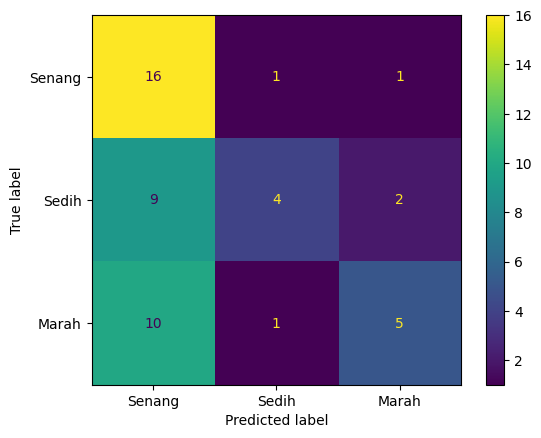

In [85]:
# Cek akurasi
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi: {acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Senang', 'Sedih', 'Marah'])
disp.plot(cmap='viridis')

In [86]:
# Kurangi fitur ke 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Split data PCA
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)


In [87]:
# Ganti kernel menjadi polynomial
svm_pca_poly = SVC(kernel='poly', degree=2)  # Degree 2 --> Binomial!
svm_pca_poly.fit(X_pca_train, y_pca_train)

SVC(degree=2, kernel='poly')

In [88]:
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

# Plot decision boundary polynomial
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

In [89]:
Z = svm_pca_poly.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

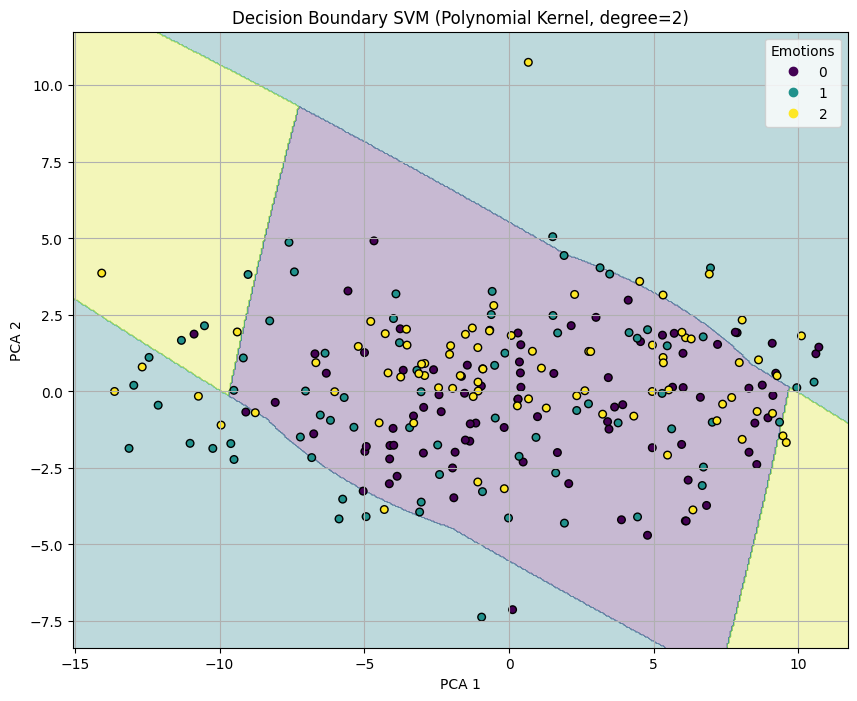

In [90]:
plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=30, edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Emotions")
plt.title('Decision Boundary SVM (Polynomial Kernel, degree=2)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid()
plt.show()

In [91]:
# --- Ambil koefisien dari SVM yang sudah di-train di PCA space ---
w = svm_pca_poly.dual_coef_
b = svm_pca_poly.intercept_

print(f"Koefisien w: {w}")
print(f"Bias b: {b}")

Koefisien w: [[ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          0.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          0.          1.          1.
   1.          1.          1.          1.          1.          0.
   1.          1.          1.          0.          0.          0.
   1.          1.          1.          1.          1.          1.
   0.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          0.43271122  1.
   0.          1.          1.          1.          0.          1.
   1.          0.          1.          1.          1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -0.43271122 -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -

ValueError: operands could not be broadcast together with shapes (187,) (100,) 

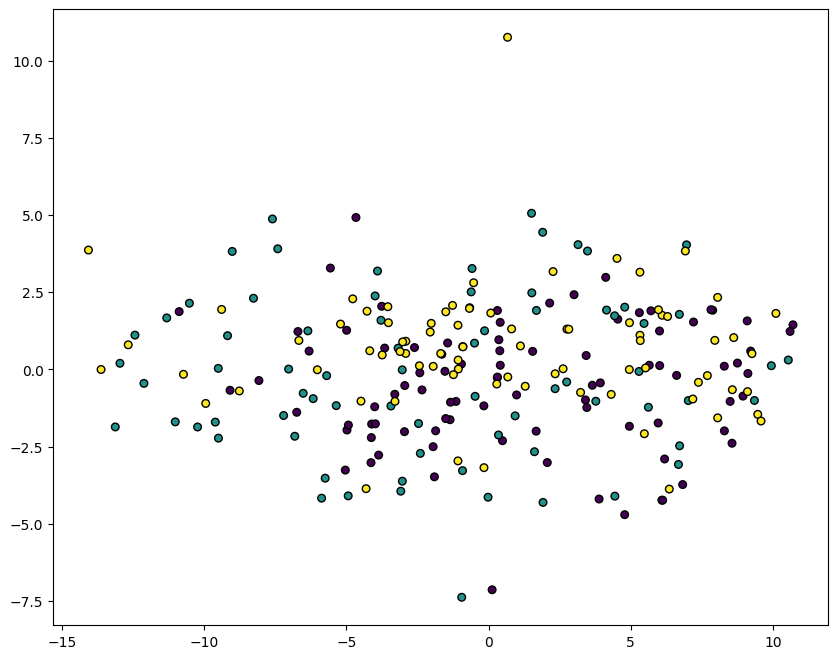

In [92]:
# --- Plot data ---
plt.figure(figsize=(10,8))

# Scatter titik data
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=30, edgecolors='k')

# Plot hyperplane
# Cari range x
x_vals = np.linspace(X_pca[:, 0].min()-1, X_pca[:, 0].max()+1, 100)

# Hitung y dari persamaan garis
# w1*x + w2*y + b = 0  -->  y = -(w1*x + b) / w2
y_vals = -(w[0] * x_vals + b) / w[1]

plt.plot(x_vals, y_vals, 'r-', label='Hyperplane')

# Tambahin juga margin (+1 dan -1)
margin = 1 / np.sqrt(np.sum(w**2))
y_margin_up = -(w[0] * x_vals + b - 1) / w[1]
y_margin_down = -(w[0] * x_vals + b + 1) / w[1]

plt.plot(x_vals, y_margin_up, 'r--', label='Margin +1')
plt.plot(x_vals, y_margin_down, 'r--', label='Margin -1')

plt.legend()
plt.title('SVM Hyperplane dan Margins')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid()
plt.show()